<a href="https://colab.research.google.com/github/Pontes-y/fiap/blob/main/fiap_ano2_fase_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from statsmodels.tsa.stattools import adfuller

# lista com os arquivos a serem analisados
arquivos = ['/content/vendas_linha_petshop_2019 - vendas_linha_petshop_2019.csv',
            '/content/vendas_linha_petshop_2020 - vendas_linha_petshop_2020.csv',
            '/content/vendas_linha_petshop_2021 - vendas_linha_petshop_2021.csv',
            '/content/vendas_linha_petshop_2022 - vendas_linha_petshop_2022.csv']

df_list = []

for arquivo in arquivos:
  df_list.append(pd.read_csv(arquivo))

df = pd.concat(df_list, ignore_index=True)

print(df)

        cod_pedido regiao_pais                              produto  valor  \
0                1       Norte         Biscoito  True Champion 300g     22   
1                2       Norte         Biscoito  True Champion 300g     21   
2                3       Norte         Biscoito  True Champion 300g     22   
3                4       Norte         Biscoito  True Champion 300g     19   
4                5       Norte         Biscoito  True Champion 300g     22   
...            ...         ...                                  ...    ...   
200781      200976     Sudeste  Bandana Disney Mickey Fábrica Petti  19,44   
200782      200977     Sudeste  Bandana Disney Mickey Fábrica Petti  21,06   
200783      200978         Sul  Bandana Disney Mickey Fábrica Petti  14,58   
200784      200979         Sul  Bandana Disney Mickey Fábrica Petti   16,2   
200785      200980         Sul  Bandana Disney Mickey Fábrica Petti  14,58   

        quantidade valor_total_bruto        data             es

In [52]:
print(df.dtypes)

cod_pedido               int64
regiao_pais             object
produto                 object
valor                   object
quantidade             float64
valor_total_bruto       object
data                    object
estado                  object
formapagto              object
centro_distribuicao     object
responsavelpedido       object
valor_comissao          object
lucro_liquido           object
categoriaprod           object
dtype: object


In [53]:
# 1.4.3 Tratando os dados nas colunas de valores
# corrigindo a coluna de data para o formato padrao YYYY-MM-DD
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month
df['ano-mes'] = pd.to_datetime(df['data']).dt.strftime('%Y-%m')

# corrigindo tipo de dado object para float
colunas_para_float = ['valor', 'valor_total_bruto', 'valor_comissao', 'lucro_liquido']
for coluna in colunas_para_float:
  df[coluna] = df[coluna].str.replace(',', '.').astype(float)

In [54]:
print(df.dtypes)

cod_pedido                      int64
regiao_pais                    object
produto                        object
valor                         float64
quantidade                    float64
valor_total_bruto             float64
data                   datetime64[ns]
estado                         object
formapagto                     object
centro_distribuicao            object
responsavelpedido              object
valor_comissao                float64
lucro_liquido                 float64
categoriaprod                  object
ano                             int64
mes                             int64
ano-mes                        object
dtype: object


In [55]:
# 1.4.1 Identificando dados missing
missings_por_linha = pd.DataFrame({'cod_pedido':df['cod_pedido'].tolist(), 'n_missing':df.isna().sum(axis=1).tolist()})

n_colunas = df.shape[1] - 1

missings_por_linha.assign(perc_missings = missings_por_linha['n_missing'] / n_colunas).sort_values('perc_missings', ascending=False).head(10)

,cod_pedido,n_missing,perc_missings
30611,30612,3,0.1875
24052,24053,3,0.1875
1180,1181,3,0.1875
46939,46940,3,0.1875
47342,47343,3,0.1875
14891,14892,3,0.1875
2141,2142,3,0.1875
47435,47436,3,0.1875
40966,40967,3,0.1875
47218,47219,3,0.1875


In [56]:
# 1.4.1 Identificando dados missing
missings_por_coluna = df.isna().sum()

missings_por_coluna = pd.DataFrame(missings_por_coluna, columns=['n'])

n_linhas = df.shape[0]

missings_por_coluna.assign(perc_missings = missings_por_coluna['n'] / n_linhas).sort_values('n', ascending=False)

,n,perc_missings
valor,50283,0.250431
valor_total_bruto,50283,0.250431
quantidade,667,0.003322
cod_pedido,0,0.000000
responsavelpedido,0,0.000000
mes,0,0.000000
ano,0,0.000000
categoriaprod,0,0.000000
lucro_liquido,0,0.000000
valor_comissao,0,0.000000


In [57]:
# 1.4.1 Tratando os dados missing
# Aplicando a media a partir da coluna valor
df['valor'] = df['valor'].fillna(df['valor_total_bruto'] / df['quantidade'])

df_agrupado = df.groupby(['regiao_pais', 'produto', 'mes'])['valor'].mean()

df = pd.merge(df, df_agrupado, on=['produto', 'regiao_pais', 'mes'], suffixes=('', '_media'))

df['valor'] = df['valor'].fillna(df['valor_media'])

df['quantidade'] = df['quantidade'].fillna(df['valor_total_bruto'] / df['valor'])

df['valor_total_bruto'] = df['valor_total_bruto'].fillna(df['valor'] * df['quantidade'])

df = df.dropna()

In [58]:
print(df)

        cod_pedido regiao_pais  \
0                1       Norte   
1                7       Norte   
3             4087       Norte   
4             5284       Norte   
5             5287       Norte   
...            ...         ...   
200781      135828         Sul   
200782      138827         Sul   
200783      141828         Sul   
200784      147826         Sul   
200785      149028         Sul   

                                                  produto       valor  \
0                            Biscoito  True Champion 300g   25.287111   
1                            Biscoito  True Champion 300g   25.287111   
3                            Biscoito  True Champion 300g   25.287111   
4                            Biscoito  True Champion 300g   25.287111   
5                            Biscoito  True Champion 300g   25.287111   
...                                                   ...         ...   
200781  Antipulgas e Carrapatos MSD Bravecto para Pet ...  352.450000   
200782 

<Axes: xlabel='quantidade', ylabel='valor'>

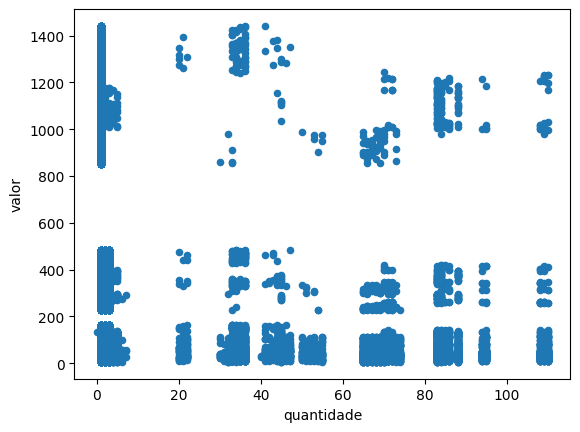

In [59]:
# 1.4.2 Analise dos outiliers nas colunas quantidade e valor, pelo metodo scatterplot
df.plot.scatter(x='quantidade', y='valor')

<Axes: xlabel='quantidade', ylabel='valor_total_bruto'>

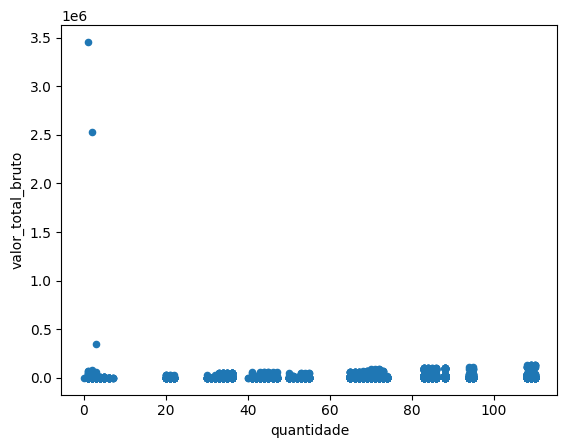

In [60]:
# 1.4.2 Analise dos outiliers na coluna quantidade pelo metodo scatterplot
df.plot.scatter(x='quantidade', y='valor_total_bruto')

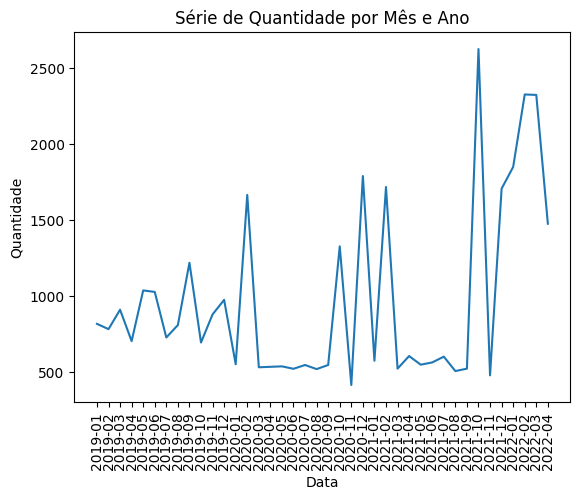

In [72]:
# 1.4.4.a Analisando o produto Biscoito  True Champion 300g
# filtrando o df pelo produto escolhido
df_filtrado = df.loc[df['produto'] == 'Biscoito  True Champion 300g']

# Agrupando os dados pela coluna ano-mes e somando as quantidades
df_agrupado = df_filtrado.groupby([df['ano-mes']])['quantidade'].sum()

# Criando o gráfico de linha
plt.plot(df_agrupado.index, df_agrupado.values)

# Configurando os eixos x e y
plt.xlabel('Data')
plt.ylabel('Quantidade')

# rotaciona os rótulos do eixo x em 90 graus
plt.xticks(rotation=90)

# Configurando o título do gráfico
plt.title('Série de Quantidade por Mês e Ano')

# Exibindo o gráfico
plt.show()

In [78]:
# 1.4.4.b Analisando estacionariedade do produto Biscoito  True Champion 300g
df_agrupado = df_agrupado.reset_index()

teste_adf = adfuller(df_agrupado['quantidade'])

print('Estatistica ADF: {:.4}'.format(teste_adf[0]))

print('p-value: {:.4}'.format(teste_adf[1]))

Estatistica ADF: 0.04751
p-value: 0.9623


In [87]:
# 1.4.4.c Analisando estacionariedade do produto Biscoito  True Champion 300g
# identificado que a serie é não estacionaria, porque p-value é maior que 0,05
# apliando o teste de estacionariedade da série transformada
teste_adf = adfuller(df_agrupado['quantidade'].diff().dropna())

print('Estatistica ADF: {:.4}'.format(teste_adf[0]))

print('p-value: {:.4}'.format(teste_adf[1]))

Estatistica ADF: -3.227
p-value: 0.01847


<Axes: >

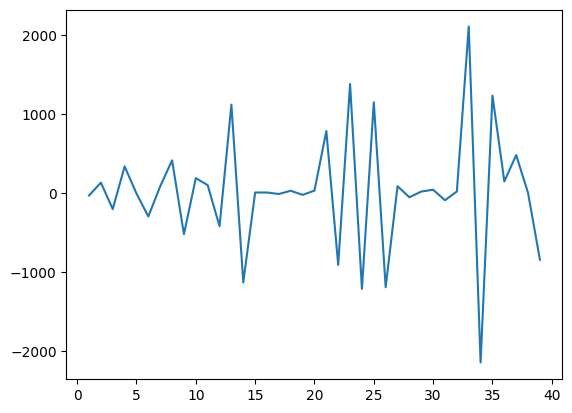

In [88]:
# 1.4.4.d Analisando estacionariedade do produto Biscoito  True Champion 300g
# com o p-value menor que 0,05 a serie se tornou estacionaria após a transformação com ordem de integração 1
df_agrupado['quantidade'].diff().plot(legend=None)

In [97]:
# 1.4.5 calculando media e mediana da quantidade de vendas por categoria
df_agrupado_vendas = df.groupby('categoriaprod')['quantidade'].agg(['mean', 'median']).reset_index()
df_agrupado_vendas.head()

,categoriaprod,mean,median
0,Acessório,3.346225,1.0
1,Alimentação,4.174317,2.0
2,Bebedouros e Comedouros,3.034158,1.0
3,Brinquedo,3.616952,1.0
4,Higiene e Limpeza,3.384394,1.0


In [109]:
# 1.4.5 calculando o rankind de produtos mais vendidos
df_ranking_vendas = df.groupby('produto')['quantidade'].sum()

# Ordena os valores em ordem decrescente
df_ranking_vendas = df_ranking_vendas.sort_values(ascending=False)

# Cria uma nova coluna com o ranking
df_ranking_vendas = df_ranking_vendas.reset_index()
df_ranking_vendas['ranking_vendas'] = df_ranking_vendas.index + 1

# Exibe o ranking
df_ranking_vendas.head(10)

,produto,quantidade,ranking_vendas
0,Biscoito True Champion 300g,38928.0,1
1,Shampoo vegano para cachorro e gato de camomil...,34673.0,2
2,Bola Pet Vinil Big Blue,34506.0,3
3,Suplemento Alimentar Glutamina Mundo Animal Nu...,34502.0,4
4,Ração Úmida Royal Canin Lata Veterinary Cães A...,34396.0,5
5,"Ração Royal Canin Exigent Gatos Adultos 1,5Kg",33766.0,6
6,Whiskas Petisco Temptations Anti Bola de Pelo 40g,33684.0,7
7,Pote Petisco Para Cachorro Bifinho Sabor Carne...,33380.0,8
8,Bandana Disney Mickey Fábrica Petti,33054.0,9
9,Ração Royal Canin Club Performance para Cães A...,32687.0,10


In [103]:
# 1.4.5 comparando media e mediana de vendas e lucro liquido
df_agrupado_lucro = df.groupby('categoriaprod')['lucro_liquido'].agg(['mean', 'median']).reset_index()

df_agrupado = pd.merge(df_agrupado_vendas, df_agrupado_lucro, on='categoriaprod', how='inner')
df_agrupado.head()

,categoriaprod,mean_x,median_x,mean_y,median_y
0,Acessório,3.346225,1.0,78.531947,23.40
1,Alimentação,4.174317,2.0,156.919791,49.00
2,Bebedouros e Comedouros,3.034158,1.0,419.874957,229.20
3,Brinquedo,3.616952,1.0,31.981485,12.24
4,Higiene e Limpeza,3.384394,1.0,102.773540,40.00


In [110]:
# 1.4.5 comparando ranking de vendas e lucro liquido
df_ranking_lucro = df.groupby('produto')['lucro_liquido'].sum()

df_ranking_lucro = df_ranking_lucro.sort_values(ascending=False)

df_ranking_lucro = df_ranking_lucro.reset_index()
df_ranking_lucro['ranking_lucro'] = df_ranking_lucro.index + 1

df_ranking = pd.merge(df_ranking_lucro, df_ranking_vendas, on='produto', how='inner')

df_ranking.head(10)

,produto,lucro_liquido,ranking_lucro,quantidade,ranking_vendas
0,Nutri Alimentador Inteligente Automático Câmer...,6520918.50,1,26131.0,19
1,Antipulgas e Carrapatos MSD Bravecto para Pet ...,5001436.75,2,32311.0,11
2,Ração Royal Canin Club Performance para Cães A...,2781729.50,3,32687.0,10
3,"Ração Royal Canin Exigent Gatos Adultos 1,5Kg",1625448.00,4,33766.0,6
4,Cama Coração Coroa Pet Nest Almofada Lavável,1473807.00,5,27372.0,17
5,Kit Banho e Tosa com Escova PetShop Cãopeon,1318294.20,6,25448.0,20
6,Vitamina E Granulado BigForce,1167909.75,7,31928.0,13
7,Cama média almofadada Pity,811968.60,8,24184.0,24
8,Suplemento Alimentar Glutamina Mundo Animal Nu...,684433.80,9,34502.0,4
9,Shampoo vegano para cachorro e gato de camomil...,664327.80,10,34673.0,2
